# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

# Problem Statement

In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The major steps that you have to perform can be briefly summarised in the following four steps:

Data Understanding: Here, you need to load the data and understand the representation.
Data Preprocessing: In this step, you will process both images and captions to the desired format.
Train-Test Split: Combine both images and captions to create the train and test dataset.
Model Building: This is the stage where you will create your image captioning model by building Encoder, Attention and Decoder model.
Model Evaluation: Evaluate the models using greedy search and BLEU score.

In [1]:
#Import all the required libraries

%pip install wordcloud
%pip install gTTs
%pip install playsound
%pip install scikit-image
%pip install keras

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns 
import glob
import matplotlib.image as mpimg
from IPython.display import Audio 

from skimage import io
pd.set_option('display.max_colwidth', None) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display
from sklearn.utils import shuffle
from nltk.translate.bleu_score import sentence_bleu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


Let's read the dataset

## Data understanding and Data preparation
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [105]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


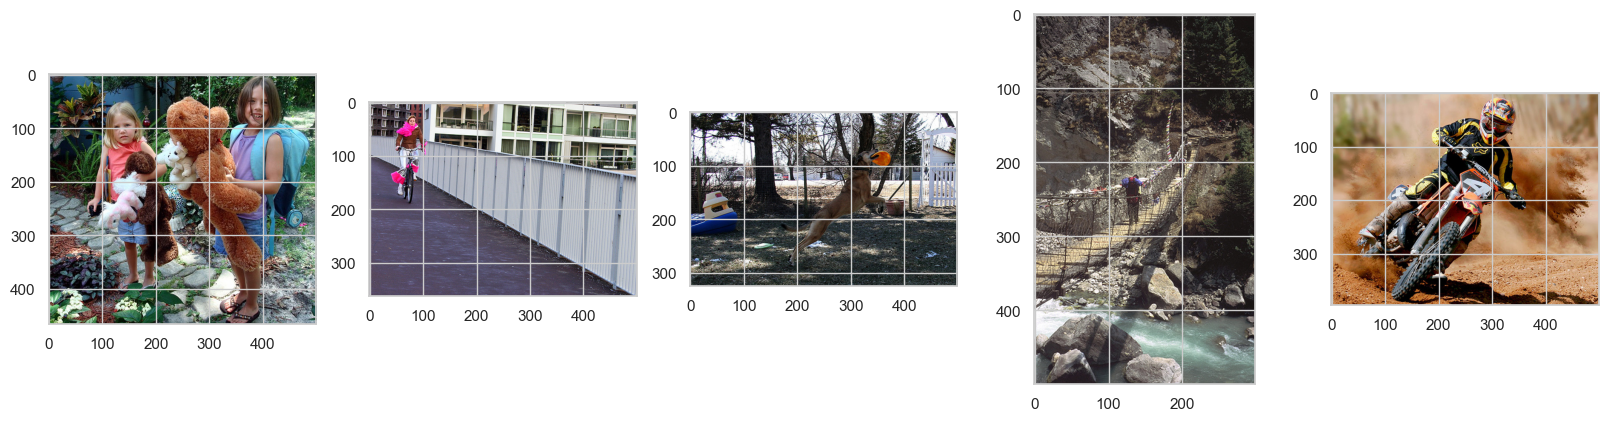

In [106]:
#Visualise both the images & text present in the dataset
Display_Images= all_imgs[20:25]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [107]:
all_imgs[0:10]

['Flickr8K/Images/2387197355_237f6f41ee.jpg',
 'Flickr8K/Images/2609847254_0ec40c1cce.jpg',
 'Flickr8K/Images/2046222127_a6f300e202.jpg',
 'Flickr8K/Images/2853743795_e90ebc669d.jpg',
 'Flickr8K/Images/2696951725_e0ae54f6da.jpg',
 'Flickr8K/Images/3421131122_2e4bde661e.jpg',
 'Flickr8K/Images/3229730008_63f8ca2de2.jpg',
 'Flickr8K/Images/3220009216_10f088185e.jpg',
 'Flickr8K/Images/3415578043_03d33e6efd.jpg',
 'Flickr8K/Images/3437273677_47d4462974.jpg']

In [108]:
#Import the dataset and read the text file into a seperate variable
def load_doc(captions):
    open_file = open(captions, 'r', encoding="latin-1") 
    text = open_file.read()
    open_file.close()    
    return text

text_buffer = load_doc('Flickr8K/captions.txt')
print(text_buffer[:1000])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [109]:
image_path = 'Flickr8K/Images/'
all_img_id = []#store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

with open('Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.'))
        all_img_vector.append(image_path+split_arr[0])
  
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   

                                                                         Captions  
0         A child in a pink dress is climbing up a set of stairs in an entry way   
1                                            A girl going into a wooden building   
2                                 A little girl climbing into a wooden playhouse   
3                             A little girl climbing the stairs to her playhouse   
4                        A little girl in a pink dress going into a wooden cabin   
...                                                                           ...  
40450                                    A man in a pink shirt climbs a rock face  
40451                                     A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453                                              A rock climber in a red shirt   
40454                           A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [110]:
vocabulary= [word for line in annotations for word in line.split()]
vocabulary[:20]

['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going']

In [111]:
image_path='Flickr8K/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   

                                                                         Captions  
0         A child in a pink dress is climbing up a set of stairs in an entry way   
1                                            A girl going into a wooden building   
2                                 A little girl climbing into a wooden playhouse   
3                             A little girl climbing the stairs to her playhouse   
4                        A little girl in a pink dress going into a wooden cabin   
...                                                                           ...  
40450                                    A man in a pink shirt climbs a rock face  
40451                                     A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453                                              A rock climber in a red shirt   
40454                           A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [113]:
vocabulary= [word for line in annotations for word in line.split()]
vocabulary[:20]


['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going']

**We can see that both 'A' and 'a' are counted separately. Therefore, let's convert all words to lowercase.**

In [114]:
#Create the vocabulary & the counter for the captions

vocabulary= [word.lower() for line in annotations for word in line.split()] #We can see that we had both

val_count=collections.Counter(vocabulary)
for key, value in list(val_count.items())[:20]:
    print(f"{key}: {value}")

a: 60196
child: 1507
in: 18174
pink: 702
dress: 332
is: 9069
climbing: 490
up: 1215
set: 105
of: 6495
stairs: 109
an: 2325
entry: 1
way: 48
girl: 3277
going: 145
into: 1046
wooden: 278
building: 485
little: 1736


a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

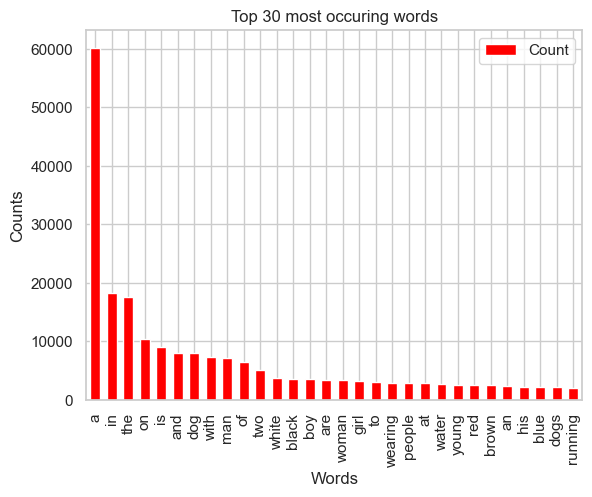

In [115]:
#Visualise the top 30 occuring words in the captions

for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
#write your code here

(-0.5, 999.5, 499.5, -0.5)

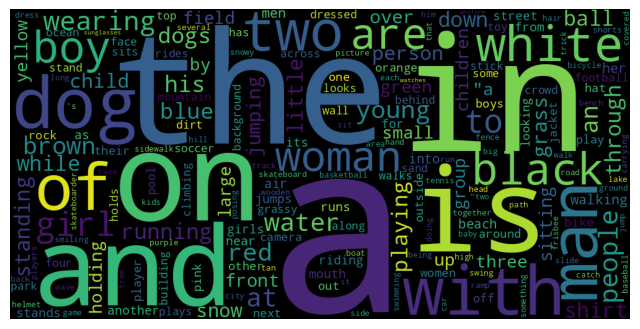

In [116]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(val_count)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')

We can see that stopwords have higher frequencies. Let's find the top 30 common words excluding them.

dog: 7948
man: 7137
two: 5132
white: 3706
black: 3620
boy: 3514
woman: 3304
girl: 3277
wearing: 2916
people: 2811
water: 2676
young: 2587
red: 2553
brown: 2457
blue: 2125
dogs: 2095
running: 1996
playing: 1954
little: 1736
shirt: 1735
standing: 1702
ball: 1678
grass: 1565
person: 1515
child: 1507
snow: 1439
jumping: 1430
front: 1322
sitting: 1322
small: 1257
three: 1251
"a: 1234
field: 1221
dict_keys(['dog', 'man', 'two', 'white', 'black', 'boy', 'woman', 'girl', 'wearing', 'people', 'water', 'young', 'red', 'brown', 'blue', 'dogs', 'running', 'playing', 'little', 'shirt', 'standing', 'ball', 'grass', 'person', 'child', 'snow', 'jumping', 'front', 'sitting', 'small', 'three', '"a', 'field'])


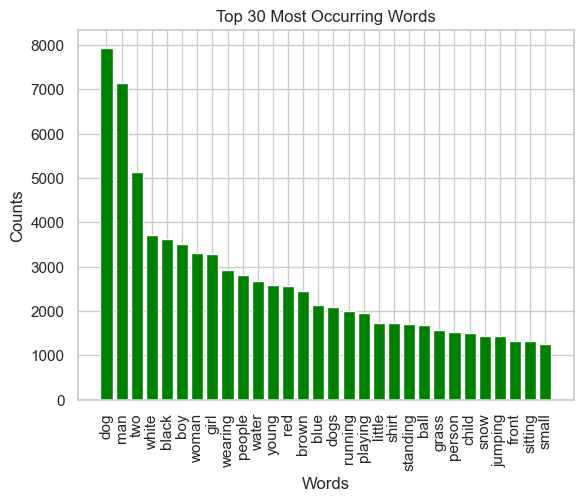

In [117]:
# Print the top 50 common words excluding stopwords
for word, count in val_count.most_common(50):
    if word not in STOPWORDS:
        print(f"{word}: {count}")

# Create a dictionary for the top 50 common words excluding stopwords
dict_without_stopwords = {word: count for word, count in val_count.most_common(50) if word not in STOPWORDS}

print(dict_without_stopwords.keys())

# Plot a bar chart for the top 30 common words excluding stopwords in green color
plt.bar(range(30), list(dict_without_stopwords.values())[:30], align='center', color='green')
plt.xticks(range(30), list(dict_without_stopwords.keys())[:30])
plt.title("Top 30 Most Occurring Words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.show()

(-0.5, 999.5, 499.5, -0.5)

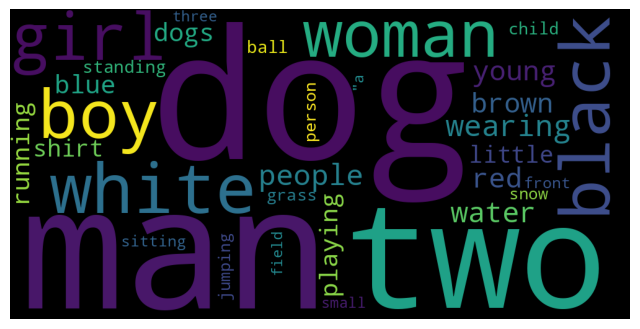

In [118]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(dict_without_stopwords)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')

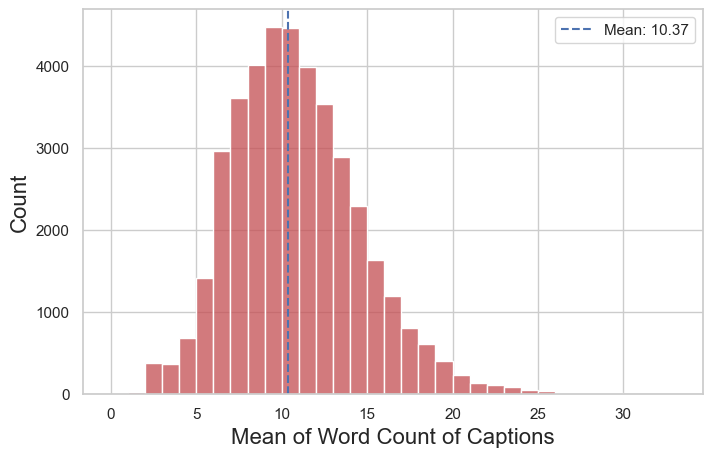

In [119]:
# Create a copy of the DataFrame and add a column for the word count of captions
caption_df = df.copy()
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

# Calculate the mean word count of captions
mean_word_count = caption_df['caption_word_count'].mean()

# Set the style and font scale for the plot
sns.set(style="whitegrid", font_scale=1)

# Create a figure for the plot
plt.figure(figsize=(8, 5))

# Plot the distribution of caption word counts
ax = sns.histplot(caption_df['caption_word_count'], bins=range(0, max(caption_df['caption_word_count']) + 1), color="r", kde=False)

# Label the axes
plt.xlabel('Mean of Word Count of Captions', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Add a vertical line for the mean word count
ax.axvline(mean_word_count, color='b', linestyle='--')

# Add a legend for the mean word count
plt.legend({'Mean: {:.2f}'.format(mean_word_count): mean_word_count})

# Show the plot
plt.show()

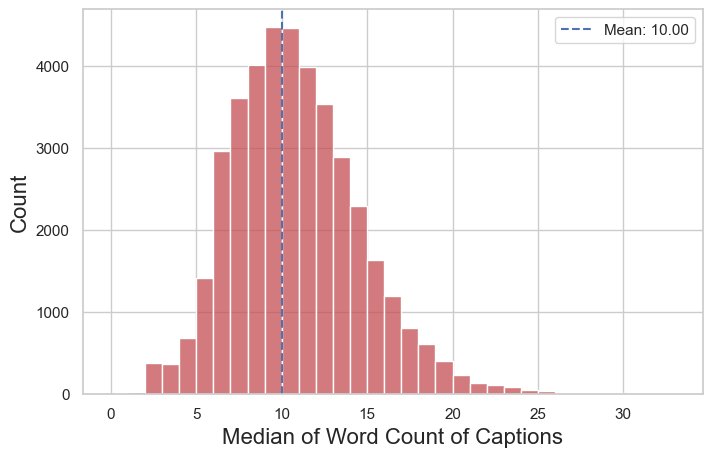

In [120]:
# Create a copy of the DataFrame and add a column for the word count of captions
caption_df = df.copy()
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

# Calculate the mean word count of captions
mean_word_count = caption_df['caption_word_count'].median()

# Set the style and font scale for the plot
sns.set(style="whitegrid", font_scale=1)

# Create a figure for the plot
plt.figure(figsize=(8, 5))

# Plot the distribution of caption word counts
ax = sns.histplot(caption_df['caption_word_count'], bins=range(0, max(caption_df['caption_word_count']) + 1), color="r", kde=False)

# Label the axes
plt.xlabel('Median of Word Count of Captions', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Add a vertical line for the mean word count
ax.axvline(mean_word_count, color='b', linestyle='--')

# Add a legend for the mean word count
plt.legend({'Mean: {:.2f}'.format(mean_word_count): mean_word_count})

# Show the plot
plt.show()

**We can see that most of the captions have 10 to 11 words**

### Visualize images and captions together.


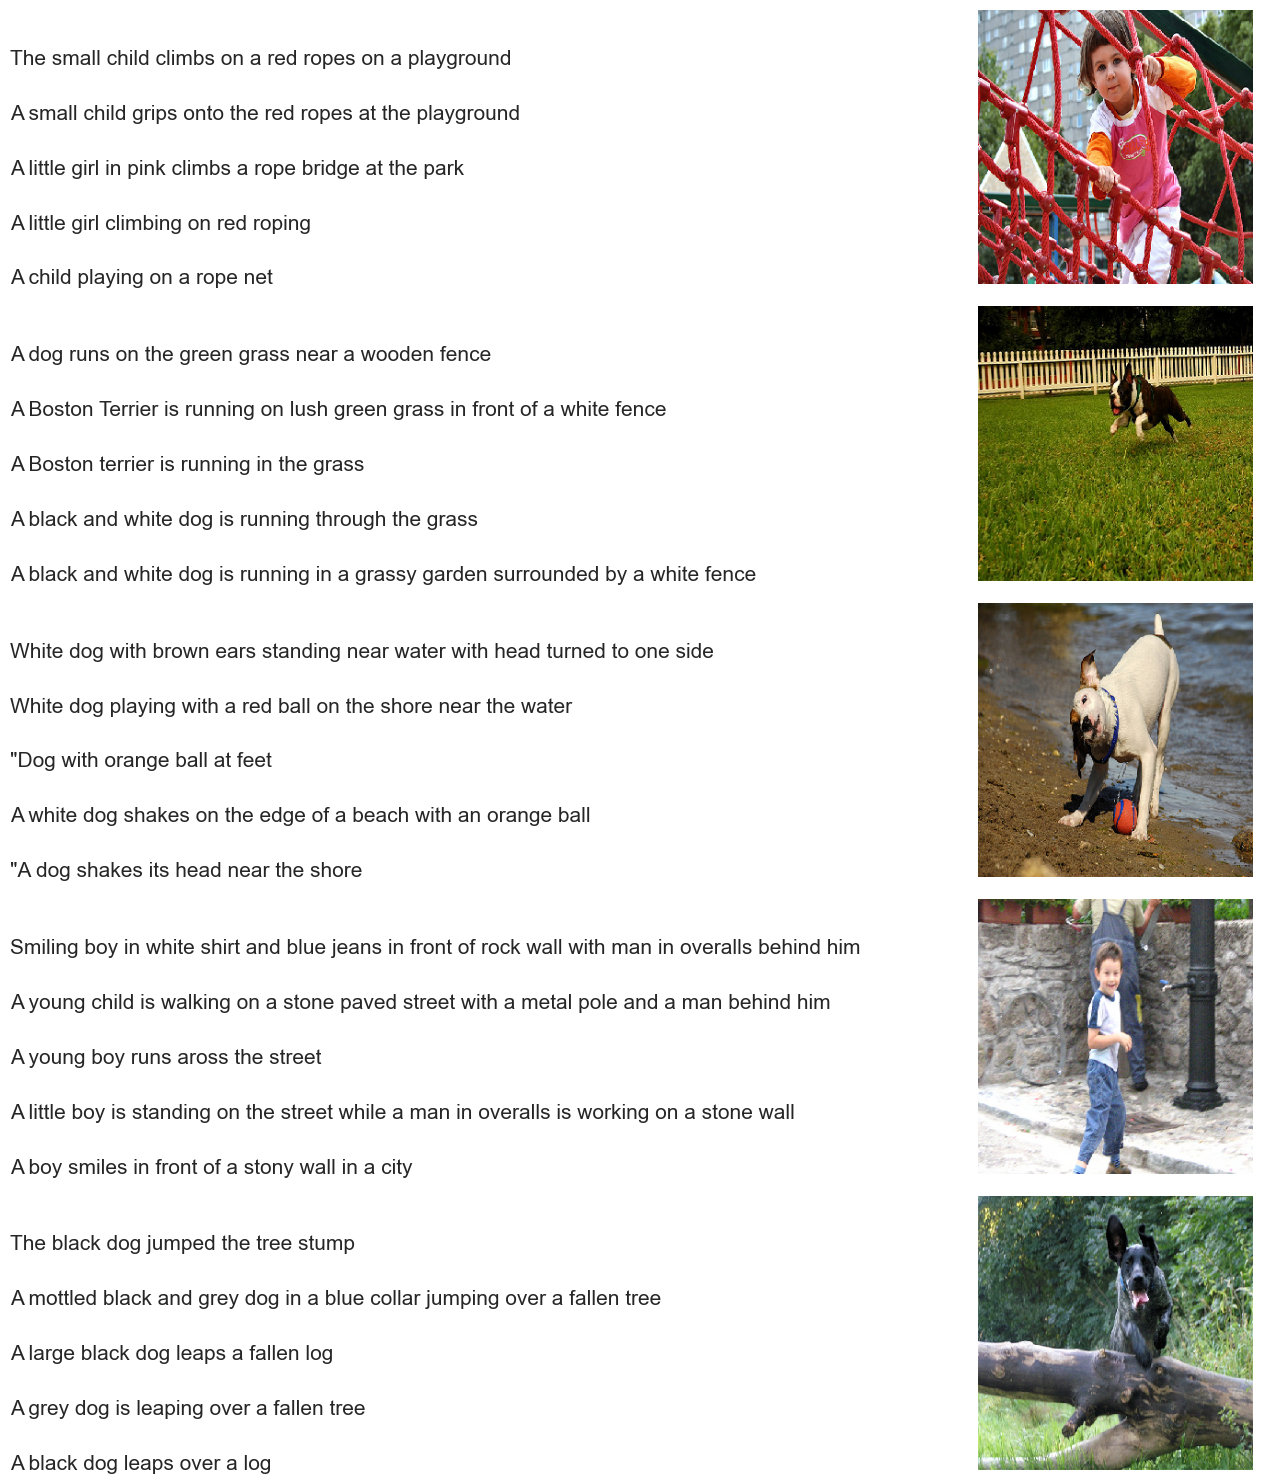

In [121]:
# Images 

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[25:50].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()



### Data Cleaning
- Convert all words to lowercase
- Remove punctuation
- Retain only words by removing numbers
- Do not remove stopwords, but remove single-letter words like 's' or 'a'
- Do not perform stemming

In [122]:
# Data cleaning
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] 
    line = [word.translate(remove_punctuation) for word in line]
    line = [word for word in line if len(word)>1] 
    line = [word for word in line if word.isalpha()]
    annotations[i]=  ' '.join(line)

### Create a list which contains all the captions

In [123]:
#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [124]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer

- Numeric characters have already been removed in the previous step.
- Remove punctuation again to ensure cleanliness (the default is all punctuation, plus tabs and line breaks, minus the ' character).
- Convert words to lowercase again to ensure consistency.
- Replace out-of-vocabulary words with the UNK token and assign the PAD token to the reserved zero index.

In [125]:
# create the tokenizer

#your code here

top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")

# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) 

train_seqs = tokenizer.texts_to_sequences(annotations)
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'


<>:6: SyntaxWarning: invalid escape sequence '\]'
<>:6: SyntaxWarning: invalid escape sequence '\]'
/var/folders/th/2d0h_mn56nlbxr2h8ygxk4780000gn/T/ipykernel_25955/1359915602.py:6: SyntaxWarning: invalid escape sequence '\]'
  tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',


In [126]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])


UNK
PAD


In [127]:
tokenizer.index_word


{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [128]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [129]:
for token, sentence in list(zip(annotations, train_seqs))[:5]:
    print(token)
    print(sentence)
    print("\n")

<start> child in pink dress is climbing up set of stairs in an entry way <end>
[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3]


<start> girl going into wooden building <end>
[2, 19, 309, 63, 193, 119, 3]


<start> little girl climbing into wooden playhouse <end>
[2, 37, 19, 115, 63, 193, 2354, 3]


<start> little girl climbing the stairs to her playhouse <end>
[2, 37, 19, 115, 5, 382, 20, 62, 2354, 3]


<start> little girl in pink dress going into wooden cabin <end>
[2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]




<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


Text(0, 0.5, 'Counts')

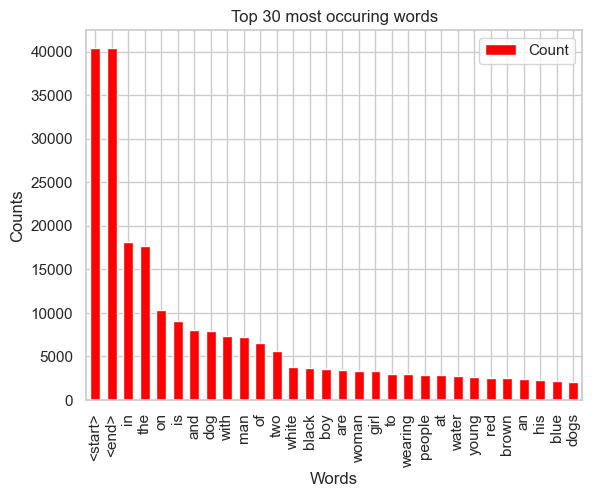

In [130]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

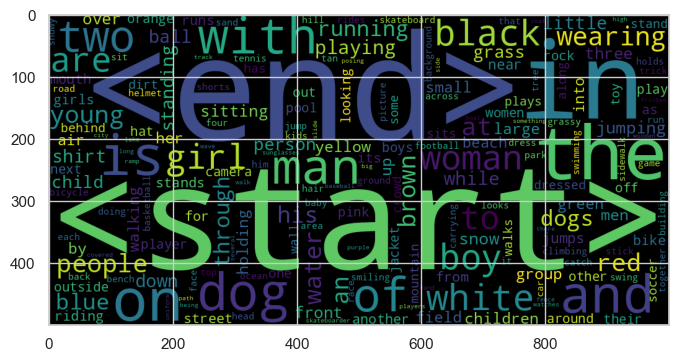

In [133]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_token);

In [135]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs_len=[len(seq) for seq in train_seqs]
longest_word_length= max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0) #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))


The shape of Caption vector is :(40455, 31)


We pad with zeros at the end using `padding='post'`. The start token acts as a prompter and expects a word to follow it. Zero indicates no word and has no value at the beginning. To avoid disrupting the existing sequence structure, we pad at the end. This padding can cause issues when creating the embedding vector, so we will apply a mask.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [137]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [138]:
# initialize model and load pretrained weights
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet') 
new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output

#model
image_features_extract_model = keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [140]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

# Create a dataset from the image paths
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector)

# Map the load_image function to the dataset
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract features and reshape them
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 2529/2529 [25:58<00:00,  1.62it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [142]:
#write your code here
    # Shuffle captions and image_names together
all_img_path, cap_vector = shuffle(all_img_path,
                                          cap_vector,
                                          random_state=1)

# Create training and validation sets using an 80-20 split
path_train, path_test, cap_train, cap_test = train_test_split(all_img_path,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=42)


In [143]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [145]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
BATCH_SIZE = 64
BUFFER_SIZE = 2000

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy') 
    return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [149]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # to load numpy files
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset



In [150]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [151]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [152]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [163]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [164]:
encoder=Encoder(embedding_dim)

### Attention model

In [165]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

The attention model performs a linear transformation of the input, followed by applying the tanh function. The features from the dense layer (FC layer) of the encoder and the hidden state of the decoder are passed through the tanh function to calculate the attention score.

In other words, the tanh function introduces a non-linear transformation to produce a smooth output. Since we need the output in the range (0,1), we apply the softmax function to the attention score to obtain the attention weights.

Finally, we compute a weighted sum of the attention weights on the feature vector to derive the context vector.

This context vector is adaptive, changing for each timestamp.

### Decoder

In [166]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

The encoder output, along with the hidden state, is passed to the attention model, which produces the context vector. This context vector is concatenated with the embedded vector from the embedding layer and then passed to the GRU. After processing the GRU output through dense layers, we obtain the final output in the shape of vocab_size, as we need to assign probabilities to each word in the vocabulary.

In [167]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [168]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [180]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [181]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [182]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [183]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
       
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [184]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        predicted_id =  tf.argmax(predictions,1)
        dec_input = tf.expand_dims(predicted_id, 1)
        
    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [185]:
def test_loss_cal(test_dataset):
    total_loss_test = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
        avg_test_loss=total_loss_test / test_num_steps

    
    return avg_test_loss

In [187]:
# model training
loss_plot = []
test_loss_plot = []
EPOCHS = 10

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 10%|█         | 1/10 [05:39<50:58, 339.79s/it]

For epoch: 1, the train loss is 0.881, & test loss is 1.974
Time taken for 1 epoch 339.73733830451965 sec

Test loss has been reduced from 100.000 to 1.974


 20%|██        | 2/10 [11:09<44:32, 334.12s/it]

For epoch: 2, the train loss is 0.820, & test loss is 1.993
Time taken for 1 epoch 330.1470251083374 sec



 30%|███       | 3/10 [16:47<39:10, 335.74s/it]

For epoch: 3, the train loss is 0.768, & test loss is 2.048
Time taken for 1 epoch 337.67705607414246 sec



2024-11-27 23:06:03.128741: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 40%|████      | 4/10 [22:21<33:29, 334.88s/it]

For epoch: 4, the train loss is 0.722, & test loss is 2.085
Time taken for 1 epoch 333.5426309108734 sec



 50%|█████     | 5/10 [27:58<27:59, 335.81s/it]

For epoch: 5, the train loss is 0.677, & test loss is 2.149
Time taken for 1 epoch 337.4642188549042 sec



 60%|██████    | 6/10 [33:40<22:31, 337.83s/it]

For epoch: 6, the train loss is 0.638, & test loss is 2.227
Time taken for 1 epoch 341.7395157814026 sec



 70%|███████   | 7/10 [39:14<16:50, 336.74s/it]

For epoch: 7, the train loss is 0.602, & test loss is 2.284
Time taken for 1 epoch 334.4978609085083 sec



 80%|████████  | 8/10 [44:45<11:09, 334.71s/it]

For epoch: 8, the train loss is 0.569, & test loss is 2.357
Time taken for 1 epoch 330.3538360595703 sec



 90%|█████████ | 9/10 [50:16<05:33, 333.70s/it]

For epoch: 9, the train loss is 0.538, & test loss is 2.409
Time taken for 1 epoch 331.49834299087524 sec



100%|██████████| 10/10 [55:48<00:00, 334.89s/it]

For epoch: 10, the train loss is 0.510, & test loss is 2.499
Time taken for 1 epoch 332.2230398654938 sec



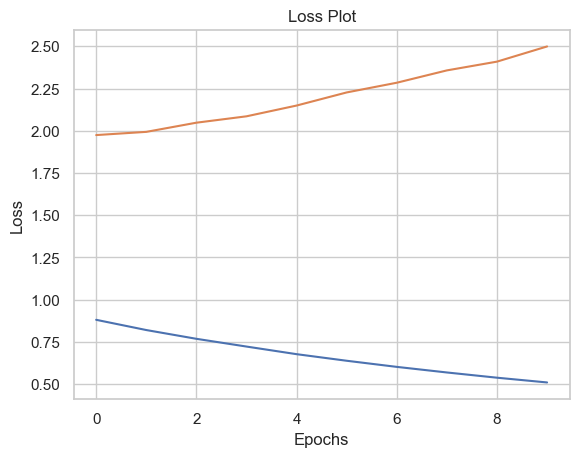

In [188]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [205]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [206]:
# to filter unwanted tokens 
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [207]:
def plot_attmap(image, result, attention_plot):

    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# Prediction:

In [208]:
# function for prediction and text to speech conversion

def pred_speech():
    # take a random image
    rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]
    
    # print original image
    print('Original image:')
    plt.imshow(mpimg.imread(test_image),interpolation='nearest',aspect='auto')
    Image.open(test_image)
    plt.title('Selected Image for testing:')
    plt.grid(None)
    print("#"*100) 
    
    # print the real caption 
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    real_caption=filt_text(real_caption)
    print ('Real Caption:', real_caption)
    print("#"*100)
    
    #print predicted caption
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    print ('Prediction Caption:', pred_caption)
    print("#"*100)
    
    # to print Belu score    
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    
    # Belu score for different weights
    print('BELU score 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
    print('BELU score 2-gram: %f' % sentence_bleu(reference, candidate, weights=(.5, .5, 0, 0)))
    print('BELU score 3-gram: %f' % sentence_bleu(reference, candidate, weights=(.33, .33, .33, 0)))
    print('BELU score 4-gram: %f' % sentence_bleu(reference, candidate, weights=(.25, .25,.25, .25)))
    print("#"*100)
    
    # to plot Captions generated by Attention model along with images 
    print('Captions generated by Attention model:')
    plot_attmap(test_image, result, attention_plot)
    print("#"*100)

    # to convert text to speech
    print('Audio for the predicted caption:')                      
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    txt_spch.save("text_to_speech.mp3")                      
                          
                          

## Testing:

Original image:
####################################################################################################
Real Caption: large brown dog runs through large grassy area
####################################################################################################
Prediction Caption: dog trotting through the yard
####################################################################################################
BELU score 1-gram: 0.219525
BELU score 2-gram: 0.000000
BELU score 3-gram: 0.000000
BELU score 4-gram: 0.000000
####################################################################################################
Captions generated by Attention model:


/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.


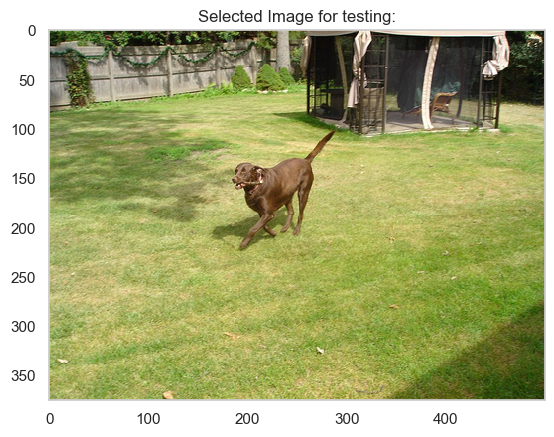

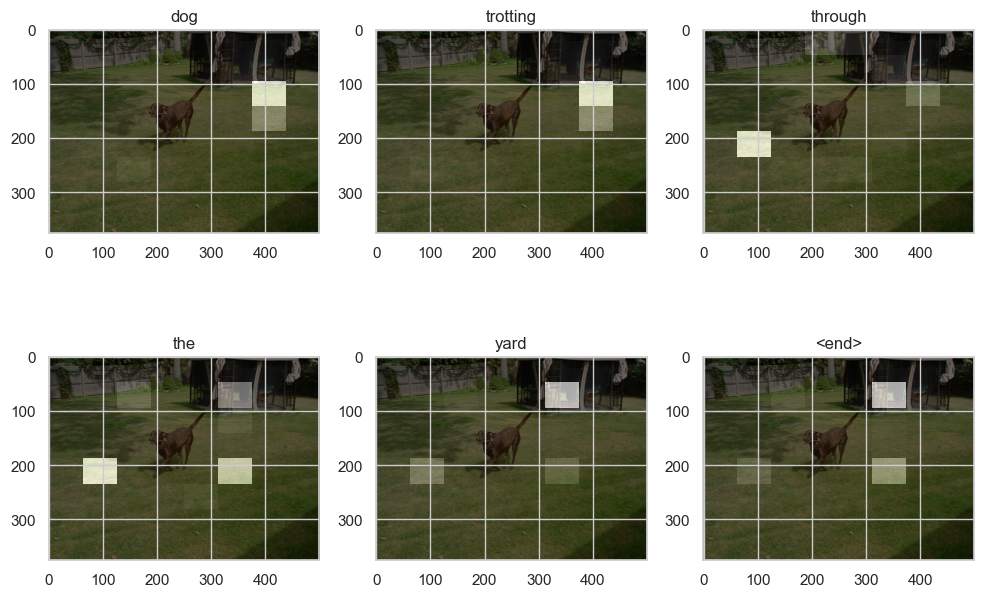

####################################################################################################
Audio for the predicted caption:


In [ ]:
#test 1
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: UNK are two young ladies sitting on crates with big smiles
####################################################################################################
Prediction Caption: two women sitting in front of an outdoor table
####################################################################################################
BELU score 1-gram: 0.177942
BELU score 2-gram: 0.000000
BELU score 3-gram: 0.000000
BELU score 4-gram: 0.000000
####################################################################################################
Captions generated by Attention model:


/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.


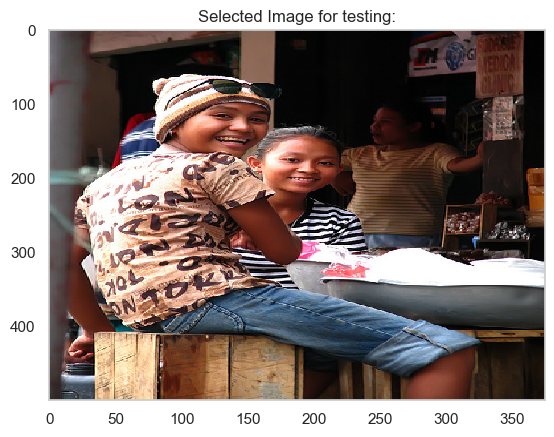

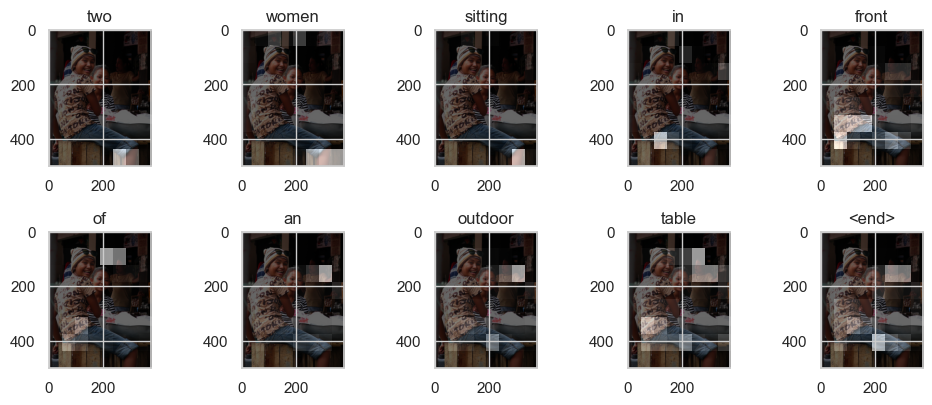

####################################################################################################
Audio for the predicted caption:


In [218]:
#test 2
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: woman in dress and baseball cap sits next to the water
####################################################################################################
Prediction Caption: woman is sitting in the water
####################################################################################################
BELU score 1-gram: 0.289732
BELU score 2-gram: 0.158693
BELU score 3-gram: 0.000000
BELU score 4-gram: 0.000000
####################################################################################################
Captions generated by Attention model:


/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/nikhil/.pyenv/versions/3.12.0/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


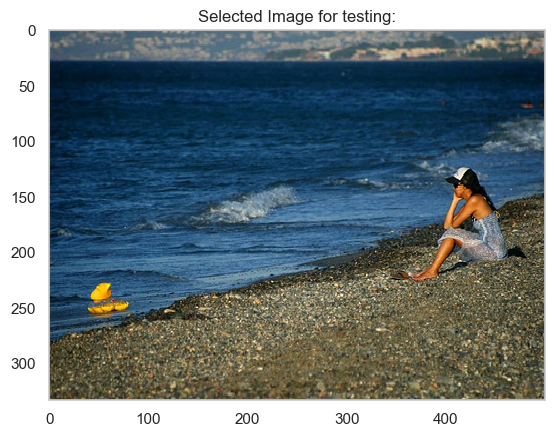

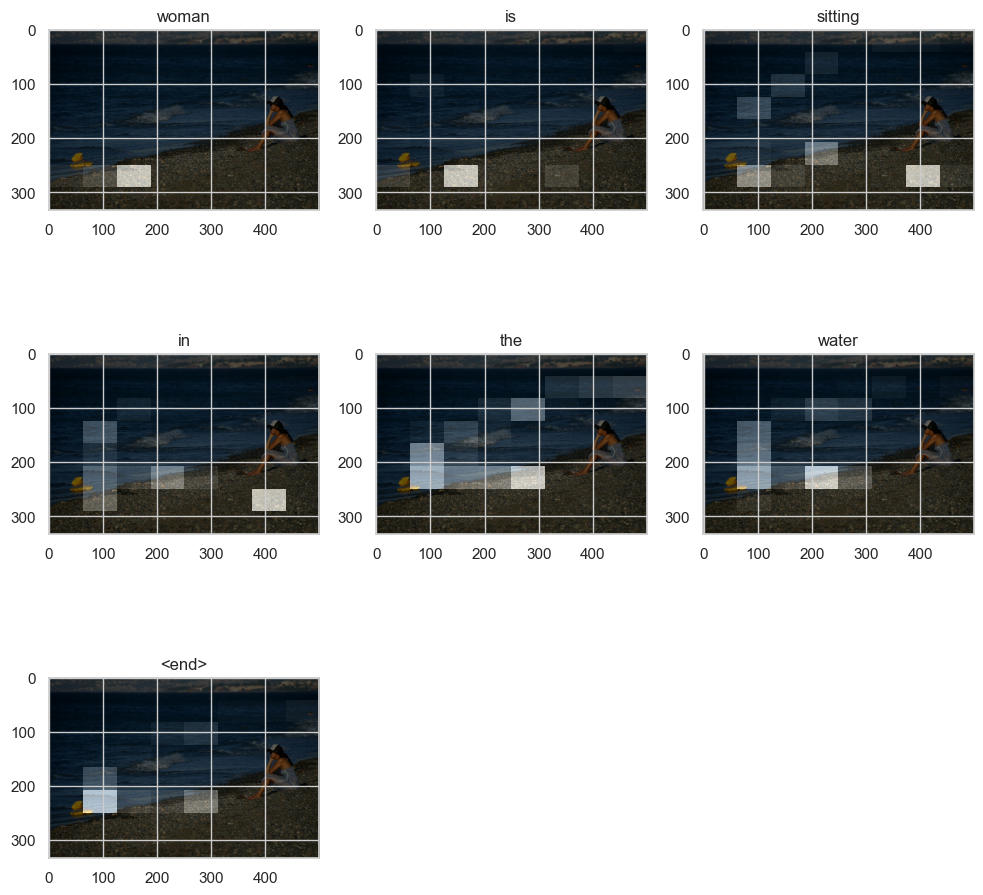

####################################################################################################
Audio for the predicted caption:


In [221]:
#test 3
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)